# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Variable Renewable Energy (VRE) assessment and forecast

### Project objectives
<div class="alert alert-block alert-info">

- Assess the onshore wind or solar photovoltaic hourly production over in metropolitan France regions using climate data and capacity factor observations.
- Predict the VRE power ahead of time.
</div>

### Dataset

- Observed monthly VRE capacity factors averaged over metropolitan France regions from 2014 to 2021
- Climate variables of your choice from a global reanalysis with an hourly sampling from 2010 to 2019

### First steps

- Choose from solar or wind power
- Read about solar/wind production assessment and forecast
- Estimate the hourly solar/wind production

### Reading the data

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [9]:
# Directories where you saved the data
data_dir_energy = Path('./energy_france')
data_dir_climate = Path('./climate_france')

In [10]:
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

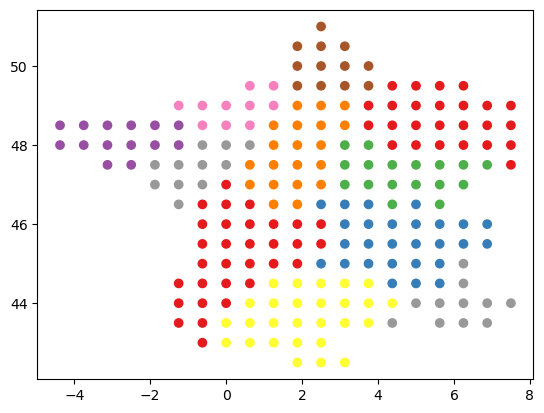

In [11]:
# Read and plot grid point-region mask
filepath_mask = Path(data_dir_climate, filename_mask)
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')

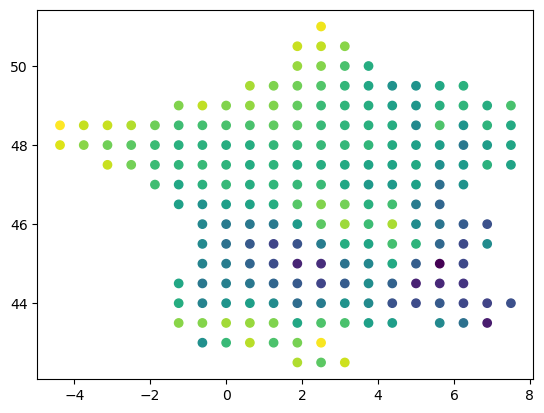

In [12]:
# Read a climate variable and plot its mean over time
variable_name = 'zonal_wind'
filename = filename_climate.format(variable_name)
filepath = Path(data_dir_climate, filename)
da_climate = xr.load_dataset(filepath)[variable_name]
plt.figure()
plt.scatter(da_mask['lon'], da_mask['lat'], c=da_climate.mean('time'))

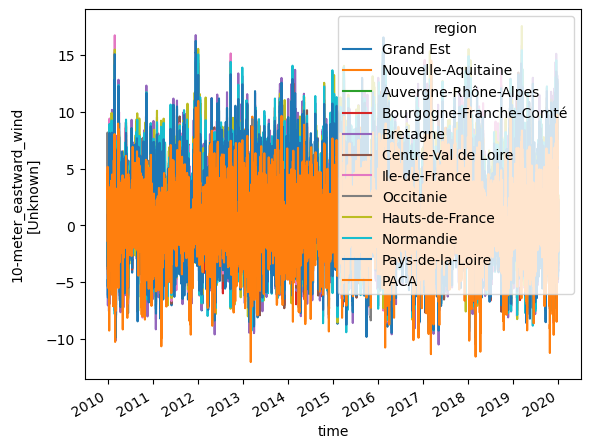

In [13]:
# Compute regional mean of climate variable and plot time series
da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
da_climate_reg['region'] = ds_mask['region'].values
plt.figure()
da_climate_reg.plot.line(x='time')

<Axes: xlabel='time'>

<Figure size 640x480 with 0 Axes>

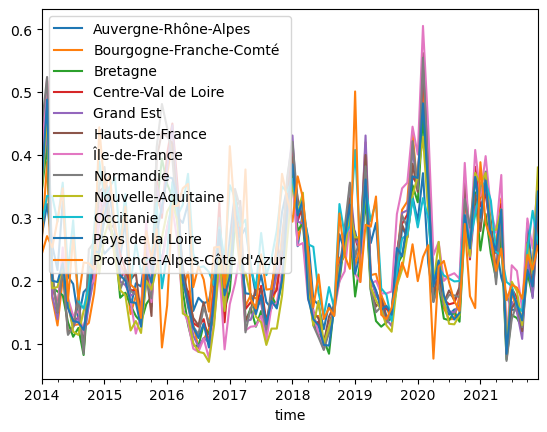

In [14]:
# Read energy variable and plot time series
variable_name = 'capacityfactor_wind-onshore'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
plt.figure()
df_energy.plot()

Arrange all the data as variables and store the DataFrame into a dictionary by region.

In [16]:
variables = [
    "height_500",
    "meridional_wind",
    "surface_density",
    "surface_downward_radiation",
    "surface_specific_humidity",
    "surface_temperature",
    "upper_meridional_wind",
    "upper_zonal_wind",
    "zonal_wind"
]

region_dfs = {region: pd.DataFrame() for region in ds_mask['region'].values}

for variable_name in variables:
    filename = filename_climate.format(variable_name)
    filepath = Path(data_dir_climate, filename)
    
    da_climate = xr.load_dataset(filepath)[variable_name]
    da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
    da_climate_reg['region'] = ds_mask['region'].values

    df_climate_reg = da_climate_reg.to_dataframe().reset_index()
    df_climate_reg = df_climate_reg.pivot(index='time', columns='region', values=variable_name)
    df_climate_mon = df_climate_reg.resample('ME').mean()
    
    for region in ds_mask['region'].values:
        region_data = df_climate_mon[[region]].rename(columns={region: variable_name})
        region_dfs[region] = pd.concat([region_dfs[region], region_data], axis=1)

Adjust region names to merge energy and climate data

In [18]:
region_name_mapping = {
    'PACA': 'Provence-Alpes-Côte d\'Azur',
    'Ile-de-France': 'Île-de-France',
    'Hauts-de-France': 'Hauts-de-France',
    'Nouvelle-Aquitaine': 'Nouvelle-Aquitaine',
    'Bourgogne-Franche-Comté': 'Bourgogne-Franche-Comté',
    'Pays-de-la-Loire': 'Pays de la Loire',
    'Grand Est': 'Grand Est',
    'Normandie': 'Normandie',
    'Occitanie': 'Occitanie',
    'Centre-Val de Loire': 'Centre-Val de Loire',
    'Auvergne-Rhône-Alpes': 'Auvergne-Rhône-Alpes',
    'Bretagne': 'Bretagne'
}

region_dfs_renamed = {
    region_name_mapping.get(region, region): df_region
    for region, df_region in region_dfs.items()
}

df_energy.index = df_energy.index + pd.offsets.MonthEnd(0)

merged_dfs = {}

for region, df_region in region_dfs_renamed.items():
    if region in df_energy.columns:
        df_region.index = pd.to_datetime(df_region.index)
        common_index = df_region.index.intersection(df_energy.index)
        df_region_trimmed = df_region.loc[common_index]
        df_energy_trimmed = df_energy.loc[common_index, [region]].rename(columns={region: 'ENERGY'})
        merged_dfs[region] = pd.concat([df_region_trimmed, df_energy_trimmed], axis=1)


In [30]:
merged_dfs['Provence-Alpes-Côte d\'Azur']

,height_500,meridional_wind,surface_density,surface_downward_radiation,surface_specific_humidity,surface_temperature,upper_meridional_wind,upper_zonal_wind,zonal_wind,ENERGY
time,,,,,,,,,,
2014-01-31,5524.048828,-0.554036,1.154800,71.862656,0.004513,277.735748,-0.740573,-0.879295,-0.569763,0.243
2014-02-28,5510.149414,-0.308148,1.156319,109.298225,0.004303,277.511414,-0.513948,-0.004821,0.000273,0.271
2014-03-31,5580.566895,-1.396081,1.148395,190.126694,0.004342,280.639862,-1.946876,-0.506542,-0.314105,0.253
2014-04-30,5617.216797,-1.155336,1.131832,238.202469,0.005633,284.006226,-1.676035,0.432083,0.411264,0.296
2014-05-31,5651.019043,-0.967272,1.127582,279.203186,0.005875,285.743683,-1.456626,0.539007,0.479057,0.347
...,...,...,...,...,...,...,...,...,...,...
2019-08-31,5841.077148,0.182144,1.092607,260.528534,0.009224,295.193756,-0.025757,0.622122,0.544105,0.157
2019-09-30,5799.360840,-1.071282,1.109234,212.587753,0.007838,291.204926,-1.592078,0.494689,0.447579,0.197
2019-10-31,5741.452148,-0.038111,1.122639,135.715454,0.007645,287.195953,-0.128113,-0.725049,-0.476192,0.229


***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>